# A Comparison of U.S. Flight Delays Over 3 Decades
## by Matt Brendel

## Preliminary Wrangling

The dataset consists of flights in the United States, including carriers, arrival and departure delays, and reasons for delays in 1988, 1998, and 2008.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

Load datasets into pandas dataframes, print statistics, describe properties, understand if and how I'll want to merge data.

In [2]:
# load dataset into a pandas dataframe
flt88 = pd.read_csv('1988.csv')
flt98 = pd.read_csv('1998.csv')
flt08 = pd.read_csv('2008.csv')

In [3]:
# concatenate datasets into one df 
flts = pd.concat([flt88, flt98, flt08], ignore_index=True)

In [4]:
# change default from hiding some columns when printing
pd.set_option('display.max_columns', None)
# high-level overview of data shape and composition
print(flts.shape)
print(flts.dtypes)
print(flts.head(8))

(17596545, 29)
Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum               object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
CancellationCode      object
Diverted               int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtype: object
   Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  1988      1           9          6   1348.0        1331 

In [5]:
flts.DepDelay.max()

2467.0

In [6]:
# descriptive statistics for numeric variables
print(flts.describe())

               Year         Month    DayofMonth     DayOfWeek       DepTime  \
count  1.759654e+07  1.759654e+07  1.759654e+07  1.759654e+07  1.726563e+07   
mean   1.999027e+03  6.461639e+00  1.573107e+01  3.937852e+00  1.348952e+03   
std    8.267026e+00  3.428922e+00  8.793604e+00  1.988182e+00  4.797379e+02   
min    1.988000e+03  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    1.988000e+03  3.000000e+00  8.000000e+00  2.000000e+00  9.340000e+02   
50%    1.998000e+03  6.000000e+00  1.600000e+01  4.000000e+00  1.334000e+03   
75%    2.008000e+03  9.000000e+00  2.300000e+01  6.000000e+00  1.740000e+03   
max    2.008000e+03  1.200000e+01  3.100000e+01  7.000000e+00  2.400000e+03   

         CRSDepTime       ArrTime    CRSArrTime     FlightNum  \
count  1.759654e+07  1.722263e+07  1.759654e+07  1.759654e+07   
mean   1.334481e+03  1.488513e+03  1.488222e+03  1.406565e+03   
std    4.781432e+02  5.035964e+02  4.967068e+02  1.490400e+03   
min    0.000000e+00  1.00000

### What is the structure of your dataset?

There are up to 17 million rows of flights with 29 different features (e.g. Actual Departure/Arrival Time, Scheduled Departure/Arrival Time, Carrier, Distance, Cancellation Code, etc). Most variables are numeric, but the Carriers and Airport codes are nominal category variables. We have instantiated three years worth of flight data, each ten years apart.

### What is/are the main feature(s) of interest in your dataset?

I'm most interested in finding if there are any destination or arrival cities that are home to more delays or cancellations & which carriers have the best on-time performance over the three decades.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

Aside from the obvious factors that I'll need to use, such as UniqueCarrier, ArrDelay, DepDelay, Origin, etc, I'm interested to see which types of delays (CancellationCode) are more prevalent and under which circumstances (longer taxi times, longer air times, etc).

### Preliminary cleaning steps:

In [7]:
# let's see how much data we're missing
flts.isna().sum()

Year                        0
Month                       0
DayofMonth                  0
DayOfWeek                   0
DepTime                330918
CRSDepTime                  0
ArrTime                373918
CRSArrTime                  0
UniqueCarrier               0
FlightNum                   0
TailNum               5285461
ActualElapsedTime      376968
CRSElapsedTime           3230
AirTime               5514465
ArrDelay               376968
DepDelay               330918
Origin                      0
Dest                        0
Distance                11102
TaxiIn                5353745
TaxiOut               5339154
Cancelled                   0
CancellationCode     17459111
Diverted                    0
CarrierDelay         16071810
WeatherDelay         16071810
NASDelay             16071810
SecurityDelay        16071810
LateAircraftDelay    16071810
dtype: int64

Since we're missing >90% of the data for the following variables, we will drop those columns entirely. It would have been interesting to run analysis on some of those values, but we'll save that for a different time. Before we start in on cleaning, let's copy the DataFrame so we can preserve the original.<br>
['CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

In [8]:
# copy original df to perform adhoc cleaning
flts_c = flts.copy()

In [9]:
# drop columns with a majority of missing data, or cols we simply won't need for analysis
flts_c = flts_c.drop(['TailNum', 'CancellationCode', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1)
# check
flts_c.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1988,1,9,6,1348.0,1331,1458.0,1435,PI,942,70.0,64.0,NaN,23.0,17.0,SYR,BWI,273.0,NaN,NaN,0,0
1,1988,1,10,7,1334.0,1331,1443.0,1435,PI,942,69.0,64.0,NaN,8.0,3.0,SYR,BWI,273.0,NaN,NaN,0,0
2,1988,1,11,1,1446.0,1331,1553.0,1435,PI,942,67.0,64.0,NaN,78.0,75.0,SYR,BWI,273.0,NaN,NaN,0,0
3,1988,1,12,2,1334.0,1331,1438.0,1435,PI,942,64.0,64.0,NaN,3.0,3.0,SYR,BWI,273.0,NaN,NaN,0,0
4,1988,1,13,3,1341.0,1331,1503.0,1435,PI,942,82.0,64.0,NaN,28.0,10.0,SYR,BWI,273.0,NaN,NaN,0,0


As for the remaining missing values, since the dataset is larger, we at first thought that we could simply remove all remaining NA rows, but we saw that that leaves us with zero 1988 data. Since we may still be interetsed in examining time-series performance across the three decades, we'll instead fill missing values for the columns we're interested in with the means from existing data.

In [10]:
# fill NAs with means for columns where it makes sense to do so (minutes, miles, etc)
fill_mean = ['ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut'];
for col in fill_mean:
    flts_c[col].fillna(flts_c[col].mean(), inplace=True)

In [11]:
# let's look at counts by airline carrier
flts_c.UniqueCarrier.value_counts()

WN        2279245
DL        2121009
AA        1953561
UA        1785118
US        1644002
NW        1306604
CO        1154759
OO         567159
TW         549892
MQ         490693
PI         470957
AS         393144
EA         389292
HP         383942
XE         374510
EV         280575
9E         262208
FL         261684
YV         254930
OH         197607
B6         196091
F9          95762
PA (1)      72264
HA          61826
PS          41911
AQ           7800
Name: UniqueCarrier, dtype: int64

Imagining ahead to when we'll want to conduct our analysis on delays by carrier, the above list of unique carriers is too large. We will have too many data streams to consider and I'm predicting future charts will be noisy, so I'll cut this list down to the top five. The 5 carriers that make up the majority of our flt dataset make sense to keep for conducting our analysis, as they are the largest and most commonly flown airlines in a colloquial sense, as well.

In [12]:
# constrain df to only rows where carriers are from top 5
flts_c = flts_c[flts_c['UniqueCarrier'].isin(['WN','DL','AA','UA','US'])]
# check
flts_c.UniqueCarrier.value_counts()

WN    2279245
DL    2121009
AA    1953561
UA    1785118
US    1644002
Name: UniqueCarrier, dtype: int64

We will want to look at the Delay columns, primarily, to inform our analysis. We get the sense that ArrDelay and DepDelay would be highly correlated, since if the plane is delayed leaving, it will likely be delayed in arrival, as well, unless there are great tailwinds helping the jet travel faster than originally predicted. Since we don't have any wind data here, we'll assume that departure delays would carry forward to informing arrival delays, as well. Let's look briefly to see if that lines up:

In [13]:
flts_c.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
37716,1988,1,1,5,1402.0,1030,2002.0,1534,UA,1,600.0,544.0,103.550143,268.0,212.0,ORD,HNL,4243.0,6.353673,15.570534,0,0
37717,1988,1,2,6,1041.0,1030,1606.0,1534,UA,1,565.0,544.0,103.550143,32.0,11.0,ORD,HNL,4243.0,6.353673,15.570534,0,0
37718,1988,1,3,7,1038.0,1030,1635.0,1534,UA,1,597.0,544.0,103.550143,61.0,8.0,ORD,HNL,4243.0,6.353673,15.570534,0,0
37719,1988,1,4,1,1050.0,1030,1636.0,1534,UA,1,586.0,544.0,103.550143,62.0,20.0,ORD,HNL,4243.0,6.353673,15.570534,0,0
37720,1988,1,5,2,1122.0,1030,1702.0,1534,UA,1,580.0,544.0,103.550143,88.0,52.0,ORD,HNL,4243.0,6.353673,15.570534,0,0


In just a few rows, we see a relationship whereby departure delays lead to even longer arrival delays. Let's see if this pattern holds for negative delays, or flights ahead of schedule.

In [14]:
flts_c[flts_c['ArrDelay'] < 0].sample(5)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
12621267,2008,4,13,7,2024.0,2030,2145.0,2159,UA,1181,141.0,149.0,124.000000,-14.0,-6.0,DEN,BUR,850.0,4.000000,13.000000,0,0
11989682,2008,3,11,2,851.0,900,1002.0,1028,UA,199,131.0,148.0,112.000000,-26.0,-9.0,PHL,ORD,678.0,4.000000,15.000000,0,0
3013986,1988,7,4,1,850.0,850,1141.0,1145,US,1504,111.0,115.0,103.550143,-4.0,0.0,LAX,ABQ,677.0,6.353673,15.570534,0,0
3881230,1988,9,8,4,823.0,825,957.0,1006,US,614,94.0,101.0,103.550143,-9.0,-2.0,CLE,BOS,563.0,6.353673,15.570534,0,0
11831343,2008,3,23,7,712.0,715,1218.0,1230,WN,3605,186.0,195.0,176.000000,-12.0,-3.0,TUS,MDW,1440.0,4.000000,6.000000,0,0


We see the same pattern, where flights which leave earlier, arrive even earlier than planned.

In [15]:
# calculate the correlation between the two vars
flts_c['ArrDelay'].corr(flts_c['DepDelay'])

0.8353348585202549

Since there is such a strong positive correlation between these two vars, we'll just choose the DepDelay variable throughout our analysis.

## Univariate Exploration

I'll start by looking at the distribution of departure delay (in minutes).

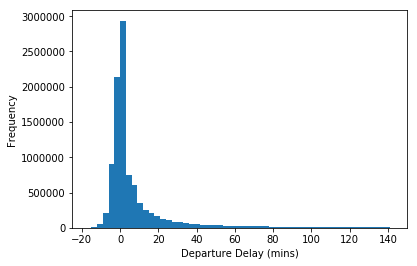

In [16]:
bin_edges = np.arange(flts_c['DepDelay'].min(), flts_c['DepDelay'].max()+3, 3);
plt.xlim(-25,150)
plt.hist(data = flts_c, x = 'DepDelay', bins = bin_edges);
plt.xlabel('Departure Delay (mins)');
plt.ylabel('Frequency');

In [17]:
# There is a long tail in the distribution, so let's put it on a log scale instead
# Since DepDelay has negative values, we need to account for them in a log_trans function by taking the absolute
# value of the delay and then reassigning the negative sign after taking the log
def log_trans(x, inverse = False):
    if not inverse:
        if x < 0:
            return np.log10(abs(x)) * -1
        elif x == 0:
            return x
        else:
            return np.log10(x)
    else:
        return np.power(10, x)
# new column in df for the log delays
flts_c['logDepDelay'] = flts_c['DepDelay'].apply(log_trans);

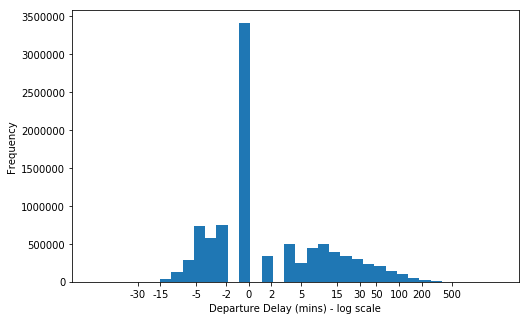

In [18]:
# plot histogram of log departure delays
plt.figure(figsize=[8, 5])
bin_edges = np.arange(flts_c['logDepDelay'].min(), flts_c['logDepDelay'].max()+0.15, 0.15);
plt.hist(data = flts_c, x = 'logDepDelay', bins = bin_edges);
tick_locs = [-30, -15, -5, -2, 0, 2, 5, 15, 30, 50, 100, 200, 500];
log_tick_locs = []
for c in tick_locs:
    log_tick_locs.append(log_trans(c))
plt.xticks(log_tick_locs, tick_locs)
plt.xlabel('Departure Delay (mins) - log scale');
plt.ylabel('Frequency');

We see that the majority of flights are on-time or very close to it (largest bar centered at 0-minute delay). We also see a relatively small peak just before the 15-min delay mark. Looking back at summary statistics, we saw that the mean delay was 8.5 mins. Since we're interested in delays for this analysis, from here forward, we will look at positive values from the DepDelay column.<br>

Next we'll look at a frequency plot for AirTime. How long are these flights typically?

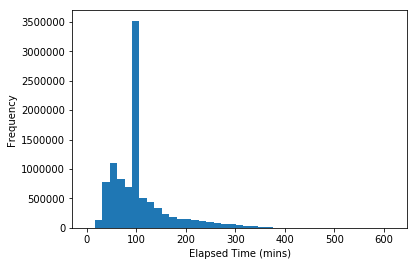

In [19]:
# histogram of AirTime
bin_edges = np.arange(flts_c['AirTime'].min(), flts_c['AirTime'].max()+15,15);
plt.hist(data = flts_c, x = 'AirTime', bins = bin_edges);
plt.xlabel('Elapsed Time (mins)');
plt.ylabel('Frequency');

We see a right-skewed distribution, which makes sense, given the average person travels further distances a fewer number of times than they travel shorter distances.

We see what appears to be an outlier or something weird in the data at 103.55 mins flight time. Looking back to when we were examining missing data, we see that there were >5M missing entries for this particular column, and we filled those in with the mean of the dataset at the time, which was 103.55! We inadvertantly dirtied our data with that assumption.

Our dataframe also contains the columns CRSElapsedTime and ActualElapsedTime, which, when looking back at summary statistics and the data dictionary, seem to represent the AirTime column similarly. Since CRSElapsedTime only had 3k missing entries, we'll use it for our analysis. A quick Google search reveals that CRS= Computerized Reservations System, so this is likely the averaged time for a flight of the given nature, anyway.

In [20]:
# we can run a quick calculation from the original dataset to validate that the mean of AirTime was 103.55
# before any cleaning had taken place
flts.AirTime.mean()

103.55014269066254

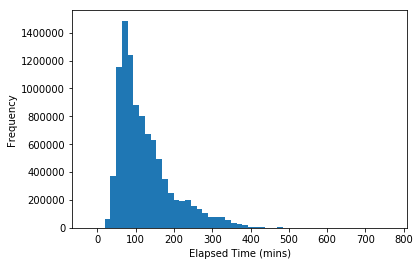

In [21]:
# histogram of CRSElapsedTime
bin_edges = np.arange(flts_c['CRSElapsedTime'].min(), flts_c['CRSElapsedTime'].max()+15,15);
plt.hist(data = flts_c, x = 'CRSElapsedTime', bins = bin_edges);
plt.xlabel('Elapsed Time (mins)');
plt.ylabel('Frequency');

The above histogram looks much more even, as we'd expect, but since it's right-skewed, we'll run a log transform to see better. Before we do, though, we notice that there are just a few negative values, which doesn't make sense for elapsed time. We'll drop those.

In [22]:
# visualize negative elapsed time
flts_c[flts_c['CRSElapsedTime'] < 0]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,logDepDelay
1550294,1988,4,3,7,130.0,130,217.0,214,DL,261,-13.000000,-16.0,103.550143,3.000000,0.0,MCO,MIA,193.0,6.353673,15.570534,0,0,0.000000
1568352,1988,4,3,7,115.0,115,209.0,213,DL,645,-6.000000,-2.0,103.550143,-4.000000,0.0,JAX,FLL,318.0,6.353673,15.570534,0,0,0.000000
1579292,1988,4,3,7,57.0,105,24.0,39,DL,886,-33.000000,-26.0,103.550143,-15.000000,-8.0,SDF,IND,111.0,6.353673,15.570534,0,0,-0.903090
1622974,1988,4,22,5,1002.0,830,NaN,919,AA,198,119.260938,-11.0,103.550143,7.508282,92.0,DFW,DTW,987.0,6.353673,15.570534,0,1,1.963788


In [23]:
# drop rows with negative elapsed time
flts_c = flts_c[flts_c['CRSElapsedTime'] >= 0]
# check
flts_c[flts_c['CRSElapsedTime'] < 0]

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,logDepDelay


In [24]:
# create column for log of elapsed time
flts_c['logCRSElapsedTime'] = flts_c['CRSElapsedTime'].apply(log_trans);

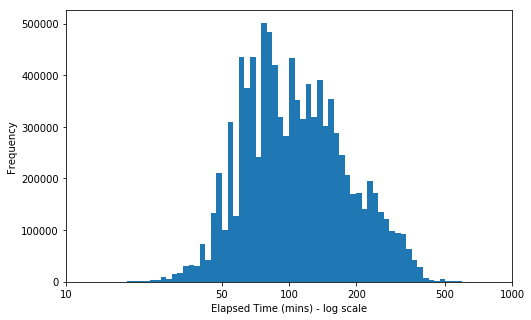

In [25]:
# histogram on log of CRSElapsedTime
plt.figure(figsize=[8, 5])
bin_edges = np.arange(flts_c['logCRSElapsedTime'].min(), flts_c['logCRSElapsedTime'].max()+0.025, 0.025);
plt.hist(data = flts_c, x = 'logCRSElapsedTime', bins = bin_edges);
tick_locs = [10, 50, 100, 200, 500, 1000];
log_tick_locs = []
for c in tick_locs:
    log_tick_locs.append(log_trans(c))
plt.xticks(log_tick_locs, tick_locs)
plt.xlim(np.log10(10),np.log10(1000))
plt.xlabel('Elapsed Time (mins) - log scale');
plt.ylabel('Frequency');

The log plot looks pretty uniform, aside from smaller peaks at ~85 and 250 mins. Those times actually make a lot of sense from a practical perspective. I've flown a good number of times around different parts of the country. I can see how there would be modes in the data at ~1.4 hour and ~4.1 hr flights. People often fly for distances that are just a bit too far to justify driving; those regional flights tend to be just under 1.5 hours (ex: Washington DC to NYC). Another popular flight is that from coast to coast. Typically those can last just over 4 hours.

Let's look at frequencies for destinations and origins next.

In [26]:
# let's get a sense of how many different destinations are contained in the dataset
flts_c.Dest.nunique()

200

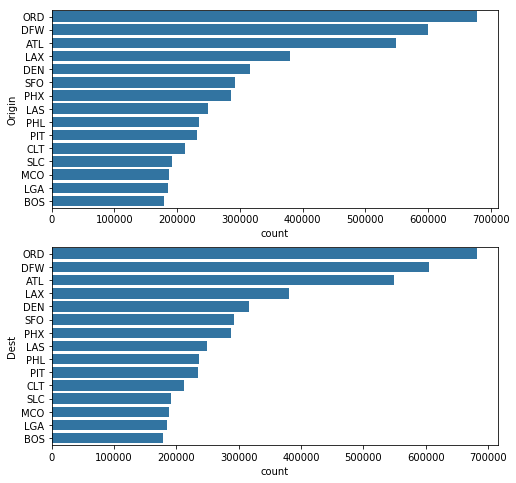

In [27]:
# Since there are 200 unique airport locations, we'll plot the top 15 to see which are the busiest for air traffic
fig, ax = plt.subplots(nrows=2, figsize = [8,8])
default_color = sb.color_palette()[0]
sb.countplot(data = flts_c, y = 'Origin', color = default_color, ax = ax[0], order = flts_c['Origin'].value_counts().iloc[:15].index)
sb.countplot(data = flts_c, y = 'Dest', color = default_color, ax = ax[1], order = flts_c['Dest'].value_counts().iloc[:15].index)
plt.show()

The Destination and Origin locations line up exactly the same in count order. ORD (Chicago) is the busiest, followed by Houston and Atlanta.

Let's look at the amount of data for Carriers and Years now.

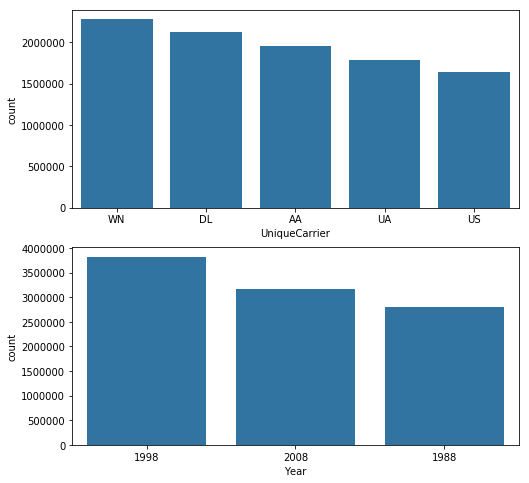

In [28]:
# countplots for Carriers and Years
fig, ax = plt.subplots(nrows=2, figsize = [8,8])
default_color = sb.color_palette()[0]
sb.countplot(data = flts_c, x = 'UniqueCarrier', color = default_color, ax = ax[0], order = flts_c['UniqueCarrier'].value_counts().index)
sb.countplot(data = flts_c, x = 'Year', color = default_color, ax = ax[1], order = flts_c['Year'].value_counts().index)
plt.show()

Southwest (WN) has the most flights in this dataset, followed by Delta. I would have expected the count of flight data to increase over time (so 2008 to have the most), but our countplot shows otherwise. This could be due to previous cleaning steps, but each year has plenty of data to still analyze across the three decades, so we're not concerned.

Let's look at which days of the week tend to have the most flights.

(1220000, 1450000)

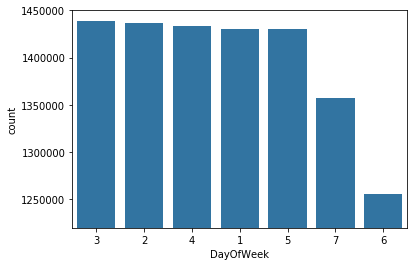

In [29]:
# countplot for Days of the week
sb.countplot(data = flts_c, x = 'DayOfWeek', color = default_color, order = flts_c['DayOfWeek'].value_counts().index)
plt.ylim(1220000,1450000)

Looks like weekdays have the most flight traffic, with Wednesdays slightly leading overall, and Saturdays have the least. Days are numbered 1-7 Mon-Sun.

Since we're done cleaning, we'll reset the index.

In [30]:
flts_c.reset_index(drop=True);

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

For the most part, the distributions for our variables of interest looked as we'd expect. As the departure delay and elapsed time variables took on a wide range of values, we produced log-transformed histograms to view a bit closer. We saw that most flights are on-time or very close to it. There was actually a greater volume of flights that left up to 5 minutes earlier than scheduled, and those that were delayed were mostly 5 mins or greater delayed. Elapsed time was mostly unimodal, centered around 110 minutes, with other apexes at about 85 and 250 minutes, as well.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

When we were first running the histogram on the AirTime variable, we noticed a large number of data points at the 103.55 min mark. We realized that this was likely a by-product of our cleaning steps when we filled in missing data with the mean. Because this didn't seem right, we moved to assessing the CRSElapsedTime variable instead.

Other data tidying steps involved concatenating multiple datasets, removing missing data, and deciding which carriers I would analyze so that I could focus the data.

## Bivariate Exploration

To start, I'll look at the pairwise correlation between the features we've examined thus far, plus Cancelled.

In [31]:
numeric_vars = ['DepDelay', 'CRSElapsedTime', 'ArrDelay', 'Cancelled']
categoric_vars = ['UniqueCarrier', 'Year', 'DayOfWeek']

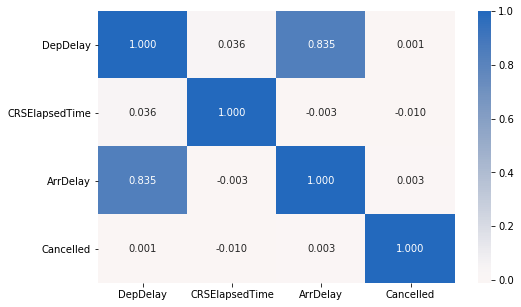

In [32]:
# correlation plot
plt.figure(figsize = [8, 5])
sb.heatmap(flts_c[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()

As we called out earlier, ArrDelay and DepDelay are highly correlated, so we will just look at DepDelay for our analysis. We also see here that elapsed flight time is not correlated with delay times at all which is expected.

We'll next look at how delay and elapsed time correlate with the categorical vars.

We will use a random sample from the larger df so that calculations will run faster. We will select a sample large enough to approximate authentic results, though. We will use the full df to run similar commands for the explanatory presentation.

<Figure size 720x720 with 0 Axes>

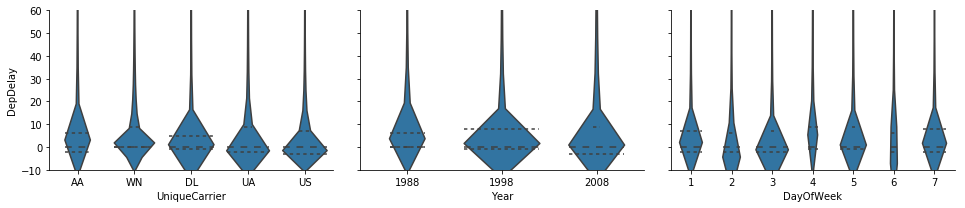

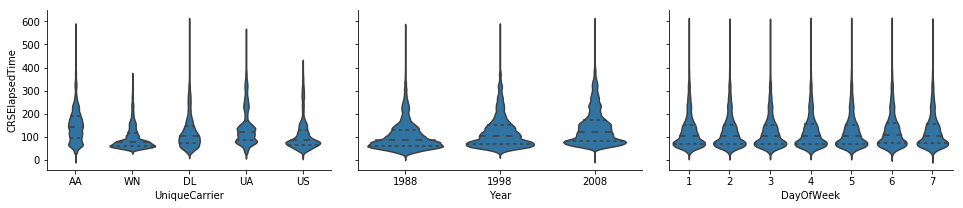

In [33]:
# plot matrix of numeric features against categorical features.
# create sample from df
flt_samp = flts_c.sample(2000000)

def violingrid(x, y, **kwargs):
    """ Quick hack for creating violin plots with seaborn's PairGrid. """
    base_color = sb.color_palette()[0]
    sb.violinplot(x, y, color = base_color, inner='quartile')

# created two separate PairGrids because I needed to set the y-axis limits to differ from seaborn's default for DepDelay
plt.figure(figsize = [10, 10])
g = sb.PairGrid(data = flt_samp, y_vars = ['DepDelay'], x_vars = categoric_vars,
                height = 3, aspect = 1.5)
g.map(violingrid)
plt.ylim(-10,60)
plt.show();

g = sb.PairGrid(data = flt_samp, y_vars = ['CRSElapsedTime'], x_vars = categoric_vars,
                height = 3, aspect = 1.5)
g.map(violingrid)
plt.show();

In these bivariate plots looking at the categorical vars against departure delay, we see that Delta Airlines (DL) has the narrowest band, inferring that there is a larger spread of delays for that carrier. Southwest seems to have the thickest centered at 0, meaning it is on-time more frequently. For the Year chart, we notice that the kernel density estimate lengthens for 1998 (indicating more variability in delay) and then widens for 2008, although the dotted-line means all seem centered at 0. We have a hard time concluding anything from the Days of the Week plot other than Mon-Thu and Sun seem to see the most delays. This makes sense, as most business travel occurs during those days.

Looking at these categorical vars plotted against flight times, we see that AA and UA have longer bands, meaning that those carriers operate longer flights on average. We see that WN, Southwest, has the thickest band. This makes sense because we know that Southwest operates chiefly in the continental US and flies mostly regional. There isn't anything to note about the Year or Days of the Week plots here.

We'll next look at the average delays and cancellations by destination.

In [34]:
# since there are too many destinations to digest at once, filter df to top 15
TopDests = ['ORD','DFW','ATL','LAX','DEN','SFO','PHX','LAS','PHL','PIT','CLT','SLC','MCO','LGA','BOS'];
flt_sampTopDest = flt_samp[flt_samp['Dest'].isin(TopDests)];

/Users/mbrendel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


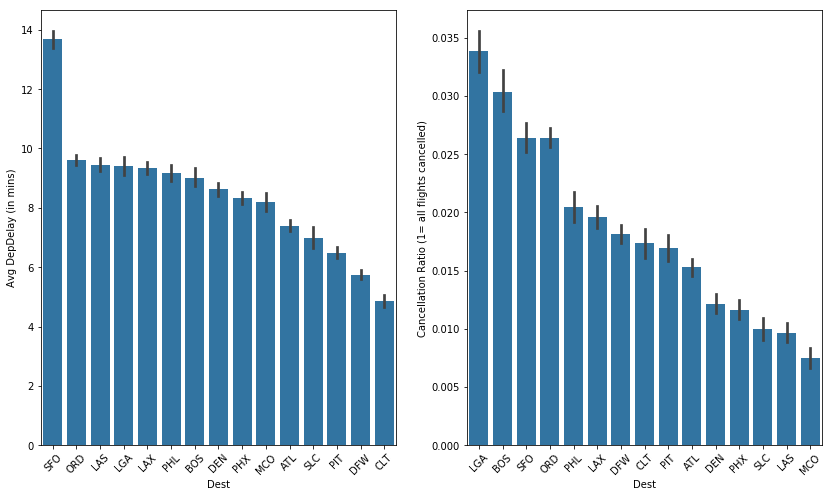

In [35]:
# declare ax and fig objects and vars of interest
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = [14,8])
base_color = sb.color_palette()[0]
yvar = ['DepDelay', 'Cancelled'];
labels = ["Avg DepDelay (in mins)", "Cancellation Ratio (1= all flights cancelled)"]
# group data by mean
group_means = flt_sampTopDest.groupby(['Dest']).mean()

for i in range(len(yvar)):
    var = yvar[i]
    # reorder by the relevant var mean
    group_order = group_means.sort_values([var], ascending = False).index
    # plot mean Delay mean by Destination
    sb.barplot(data = flt_sampTopDest, x = 'Dest', y = var, color = base_color, ax= ax[i], order = group_order)
    # rotate x-axis labels for readability
    for item in ax[i].get_xticklabels():
        item.set_rotation(45)
    ax[i].set_ylabel(labels[i]);
plt.show()

SFO airport has the highest mean delay, at just under 14 mins. Nine of the 15 destinations fall between 8-10 minute delays. We have included error bars to represent the uncertainty in the mean based on variance and sample size; their small size highlights the robust data set. The weather is usually pretty nice in California, so we don't have any immediate inferences as to why SFO would have the highest mean delay. For further investigation, it would be interesting to see if the difference between SFO and LAS is statistically significant.

We see that Boston, New York, and Chicago (airport codes) have the highest cancellation ratios. While not high (just over 3%), it makes sense that these cities would command more cancellations because they are in the Northeast, where more snow and weather issues occur.

We saw from the correlation plot earlier that DepDelay and Cancelled are not correlated. This makes sense, since the two should be mutually exclusive, from a reporting standpoint; a flight that is cancelled can not have a delay. Although, from experience, many cancelled flights start out with (multiple) delays before they end up being cancelled.

If the data set had better reporting on the WeatherDelay var, would we have found correlation between it and Cancelled?

We'll now observe average delays and cancellations by carrier.

/Users/mbrendel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


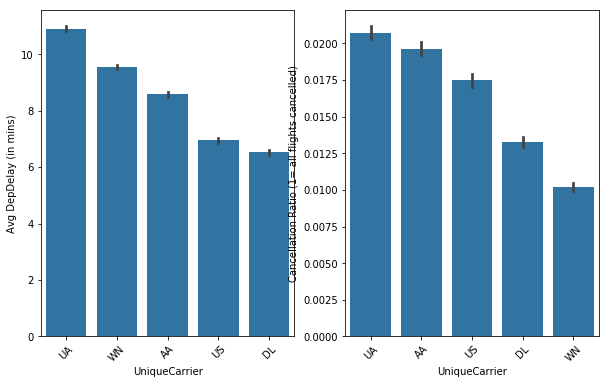

In [36]:
# declare ax and fig objects and vars of interest
fig, ax = plt.subplots(ncols = 2, nrows = 1 , figsize = [10,6])
# group data by mean - we'll also use the standard sample df, as we don't need to filter down the Destinations here
group_means = flt_samp.groupby(['UniqueCarrier']).mean()

for i in range(len(yvar)):
    var = yvar[i]
    # reorder by the relevant var mean
    group_order = group_means.sort_values([var], ascending = False).index
    # plot mean Delay mean by Destination
    sb.barplot(data = flt_samp, x = 'UniqueCarrier', y = var, color = base_color, ax= ax[i], order = group_order)
    # rotate x-axis labels for readability
    for item in ax[i].get_xticklabels():
        item.set_rotation(45)
    ax[i].set_ylabel(labels[i]);
plt.show()

We see that United Airlines has the worst performance in terms of departure delays and cancellations. Delta seems to have the best across the two factors.

Before moving to multivariate analysis, let's look at how TaxiTime (not one of our features of interest) varies with DepDelay.

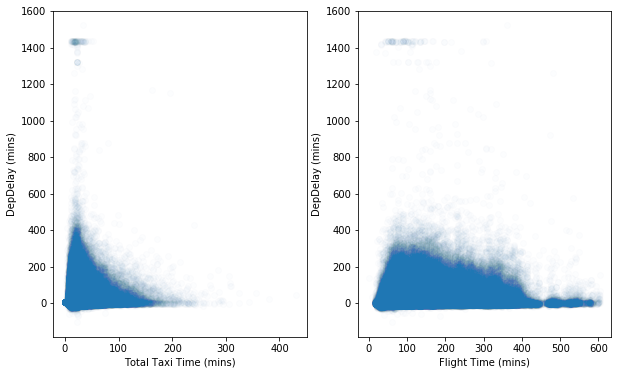

In [37]:
# use sample dataset so that scatter plots won't be as noisy
# proxy new column that captures the sum of taxi in and out time
flt_samp['TaxiTotal'] = flt_samp['TaxiIn'] + flt_samp['TaxiOut']
xvar = ['TaxiTotal', 'CRSElapsedTime']
xlabel = ['Total Taxi Time (mins)', 'Flight Time (mins)']

fig, ax = plt.subplots(ncols = 2, nrows = 1 , figsize = [10,6])
for i in range(len(xvar)):
    var = xvar[i]
    ax[i].scatter(data = flt_samp, x = var, y = 'DepDelay', alpha = 1/100)
    ax[i].set_ylabel('DepDelay (mins)')
    ax[i].set_xlabel(xlabel[i])
plt.show()

As this is exploratory data analysis, not explanatory, we didn't bother removing outliers or readjusting axes shown above. We are able to see the pattern / relationship without those steps.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

We theorize that delays have lessened over the three decades, as the kernel densities for the Year variable flatten out from 1988 to 2008.

For avg delays, we saw that SFO destination has the highest and CLT has the smallest. Most places had delays between 8 and 10 mins.

We saw that UA (United) has the highest delay, on average, as well as the highest cancellation rate. That finding aligns with my personal experience with that airline.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

We observed how Taxi Time varies with Depature Delay. We see that as taxi times increase, the limit for delays, on average, decreases. We're not entirely sure why this would be the case, unless the two variables report on the same delay, in essence; i.e. flights with a long taxi time recorded may have a smaller delay time because the delay was recorded as taxi time instead. The concavity implies we might want to perform a transformation here if this were our primary feature of interest.

When looking at flight time vs delay, we see a relative peak just under the mean flight time (~100), and then gradual decrease in delay as flight time increases. This makes sense, as the most prevalent flight time corresponds with the most in-demand domestic flight, meaning the chances of having a delay for various reasons shoot up. People pay more for longer flights, on the other hand, the trips are usually staffed better, and occur less frequently. These factors make up some reasons for not having as much delay.

## Multivariate Exploration

I want to dig a bit deeper on the relationship between departure delay/cancellation and destination; I will encode Year with color.

/Users/mbrendel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


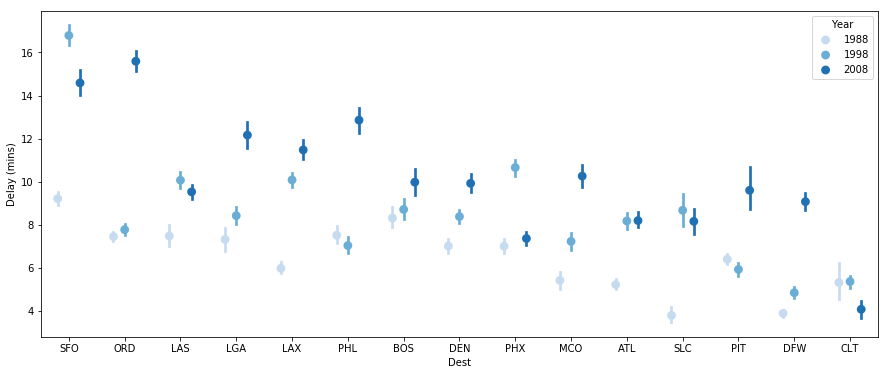

In [38]:
# set order of x-axis categorical var to align with ascending avg DepDelay
group_means = flt_sampTopDest.groupby(['Dest']).mean()
group_order = group_means.sort_values(['DepDelay'], ascending = False).index
fig = plt.figure(figsize = [15,6])
# plot pointplot with Year as the colored, third var
ax = sb.pointplot(data = flt_sampTopDest, x = 'Dest', y = 'DepDelay', hue = 'Year',
           palette = 'Blues', linestyles = '', dodge = 0.4, order= group_order)
plt.ylabel('Delay (mins)')
plt.show();

/Users/mbrendel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


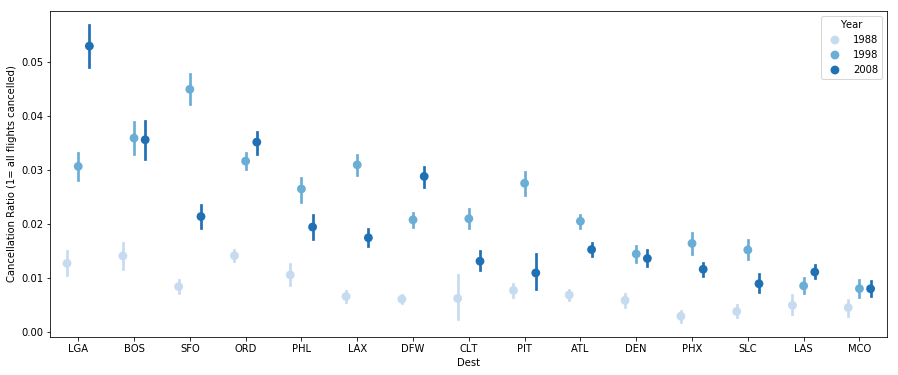

In [39]:
# set order of x-axis categorical var to align with ascending avg Cancelled
group_means = flt_sampTopDest.groupby(['Dest']).mean()
group_order = group_means.sort_values(['Cancelled'], ascending = False).index
fig = plt.figure(figsize = [15,6])
# plot pointplot with Year as the colored, third var
ax = sb.pointplot(data = flt_sampTopDest, x = 'Dest', y = 'Cancelled', hue = 'Year',
           palette = 'Blues', linestyles = '', dodge = 0.4, order= group_order)
plt.ylabel('Cancellation Ratio (1= all flights cancelled)')
plt.show();

When encoding Year as a third dimension, we see an interesting trend. It looks like delay times actually increase over the three decades, with 1988 seeing lower pointplots, on average, and 2008 (dark blue) seeing the highest, per destination. The places that counter this trend are PHX and CLT. We wonder whether this has to do with increased demand for commercial flights over time and lagging infrastructure advancement to support.

For cancellations, we see more of a hump effect; across the board for the highest-trafficed airports, flight cancellations were lowest in 1988. They spiked in 1998, and then seemed to fall again slightly looking at 2008 plots. We speculate that this could be the case as airline demand rose at the turn of the century but methods for handling long delays were not as robust; instead, flights were cancelled. As procedure and technology improved, cancellations dropped (2008). Perhaps these flights that would have been cancelled in the past are now still able to take off, but with delay - and that explains the rise in delays for 2008.

Next, we'll use a similar plot to show delays and cancellations by carrier over the three years.

/Users/mbrendel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


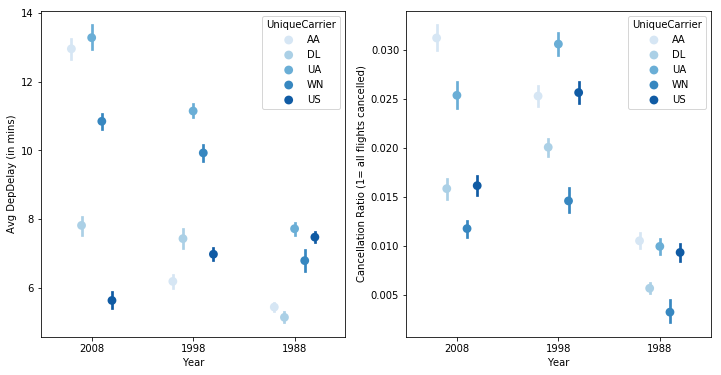

In [40]:
# declare ax and fig objects and vars of interest
fig, ax = plt.subplots(ncols = 2, nrows = 1 , figsize = [12,6])
# group data by mean - we'll also use the standard sample df, as we don't need to filter down the Destinations here
group_means = flt_samp.groupby(['Year']).mean()
yvar = ['DepDelay', 'Cancelled'];
labels = ["Avg DepDelay (in mins)", "Cancellation Ratio (1= all flights cancelled)"];

for i in range(len(yvar)):
    var = yvar[i]
    # plot mean Delay/Cancelled mean by Year, encoding Carrier with color
    # keeping Year order consistent unlike previous plots where I ordered by the mean x-var
    sb.pointplot(data = flt_sampTopDest, x = 'Year', y = var, hue = 'UniqueCarrier',
                      palette = 'Blues', linestyles = '', dodge = 0.4, ax = ax[i], order= [2008,1998,1988])
    ax[i].set_ylabel(labels[i]);
plt.show()

Delays not only increase, on average, over time, but the spread amongst top carriers also increases; in 1988, the top carriers all fell within ~5.7 to 8 min delays. In 2008, US is at ~5.8 while UA is at 13 mins. While no airline leads in smallest average delay across all three years, DL hugs the bottom of the chart the most.

On the cancellation plot, we clearly see that WN wins for having the lowest cancellation rate across all three years. UA and AA cancel the most flights across the three years plotted. This makes sense, as UA and AA are the largest conglomerate airlines; as with anything, the larger something is, the less nimble it is. It is probably harder for UA and AA to minimize cancellations, logisitically, as well as the smaller airlines like DL and WN.

In [41]:
# run some descriptive stats on the columns of interest for the next plot
flt_samp[['CRSElapsedTime','DepDelay']].describe()

,CRSElapsedTime,DepDelay
count,2.000000e+06,2.000000e+06
mean,1.238957e+02,8.510792e+00
std,7.166272e+01,2.845012e+01
min,1.000000e+00,-1.030000e+02
25%,7.100000e+01,-2.000000e+00
50%,1.030000e+02,0.000000e+00
75%,1.550000e+02,8.000000e+00
max,6.040000e+02,1.521000e+03


In [42]:
def hist2dgrid(x, y, **kwargs):
    """ Quick hack for creating heat maps with seaborn's PairGrid. """
    palette = kwargs.pop('color')
    # zoom in on top 75% of data for more granular color coding
    bins_x = np.arange(0,165+12,12)
    bins_y = np.arange(-5,18+2,2)
    plt.hist2d(x, y, bins = [bins_x, bins_y], cmap = palette, cmin = 1000)
    plt.xticks(bins_x)
    plt.yticks(bins_y)

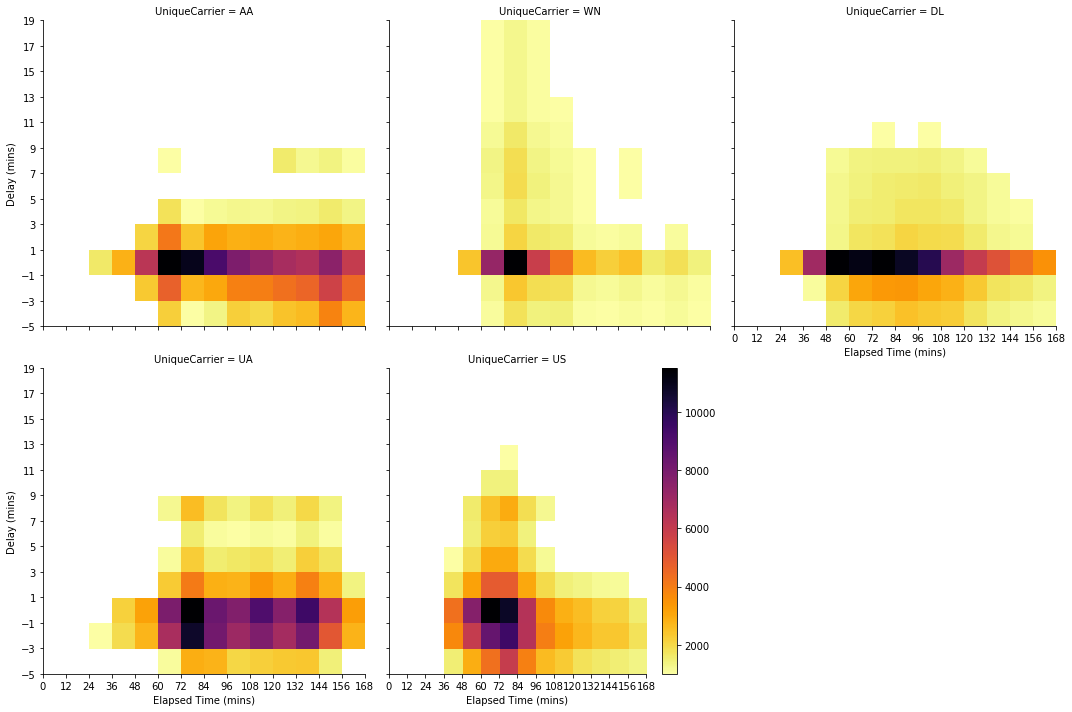

In [43]:
# create faceted heat maps on levels of the Carrier variable
g = sb.FacetGrid(data = flt_samp, col = 'UniqueCarrier', col_wrap = 3, height = 5)
g.map(hist2dgrid, 'CRSElapsedTime', 'DepDelay', color = 'inferno_r')
g.set_xlabels('Elapsed Time (mins)')
g.set_ylabels('Delay (mins)')
plt.colorbar()
plt.show()

We zoomed in on the top 75% of the data set above, so that we could interpret more granular trends.

The heat maps give us greater insight into the different carriers' flight patterns. Our findings that UA and AA serve the longest (and likely most complex) flights is backed up by how we see such a wide range of darker color across the elapsed time and delay axes; the majority of UA's flights fall between 60 and 156 mins, whereas WN has a thinner band between 60 and 72 mins. DL is more mid-range, with elapsed times between 48 and 120 mins.

The coloring also helps us bin the delays per carrier. We can see UA's delays fall distinctly between -3 to 9 mins whereas the color, albeit lighter, extends higher for WN, corroborating what we saw earlier in the longer violin plot and in the pointplot.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

As a reminder, our main questions of interest were: which destination (or arrival) cities are home to more delays or cancellations & which carriers have the best on-time performance over the three decades? We were able to create visualizations to answer both those questions and more.

In this multivariate exploration, we continued our investigation of airline flight times, delays, and cancellations and split them out by year and carrier. We interestingly saw that 2008 saw the most delays when segmented by the 15 major destination airports and that the spread in delays increased over time. We were also able to capture how WN had the lowest cancellation rate over the three years analyzed.

### Were there any interesting or surprising interactions between features?

Looking back at the point plots, it doesn't seem like there's a systematic interaction effect between these different variables, yet we do see some consistent patterns, such as 2008 having the highest delays across the major airports. We're also able to see how small-scale airlines such as WN are in comparing flight time and delay bands to UA or AA in the heat maps.